# Load Modules

In [1]:
from datetime import timedelta
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp, ttest_ind

from metrics import BacktestMetricCalculator
from utils import EmpiricalDistribution, fit_evt, add_time, resample

# Set Param

In [2]:
FREQ = "5min"
MIN_N = 3
SIGNIFICANT_LEVEL = 0.01

# Load Data

In [3]:
df = pd.read_parquet("data/spy.parquet")
df

,date,open,high,low,close,volume
time,,,,,,
2011-01-03 14:30:00+00:00,2011-01-03,126.71,126.74,126.66,126.72,2563400.0
2011-01-03 14:31:00+00:00,2011-01-03,126.72,126.79,126.69,126.79,807600.0
2011-01-03 14:32:00+00:00,2011-01-03,126.79,126.81,126.73,126.75,596000.0
2011-01-03 14:33:00+00:00,2011-01-03,126.75,126.80,126.73,126.74,455000.0
2011-01-03 14:34:00+00:00,2011-01-03,126.74,126.76,126.73,126.76,617100.0
...,...,...,...,...,...,...
2025-07-10 19:55:00+00:00,2025-07-10,625.52,625.83,625.47,625.67,682982.0
2025-07-10 19:56:00+00:00,2025-07-10,625.66,625.80,625.64,625.78,223317.0
2025-07-10 19:57:00+00:00,2025-07-10,625.78,625.85,625.72,625.84,327135.0


# Process Data
## 1. Resample data to 5 minutes frequency

In [4]:
df = resample(df, FREQ)
df

,date,open,high,low,close,volume
time,,,,,,
2011-01-03 14:30:00+00:00,2011-01-03,126.71,126.74,126.66,126.72,2563400.0
2011-01-03 14:35:00+00:00,2011-01-03,126.72,126.81,126.69,126.75,3029500.0
2011-01-03 14:40:00+00:00,2011-01-03,126.75,126.83,126.72,126.81,2734100.0
2011-01-03 14:45:00+00:00,2011-01-03,126.81,126.99,126.80,126.95,3299400.0
2011-01-03 14:50:00+00:00,2011-01-03,126.94,127.10,126.94,127.06,2825100.0
...,...,...,...,...,...,...
2025-07-10 19:40:00+00:00,2025-07-10,626.46,626.54,626.34,626.54,513147.0
2025-07-10 19:45:00+00:00,2025-07-10,626.54,626.68,626.38,626.38,796113.0
2025-07-10 19:50:00+00:00,2025-07-10,626.38,626.39,625.80,625.92,1629609.0


## 2. Add returns series (target variable) from price data

<Axes: xlabel='time'>

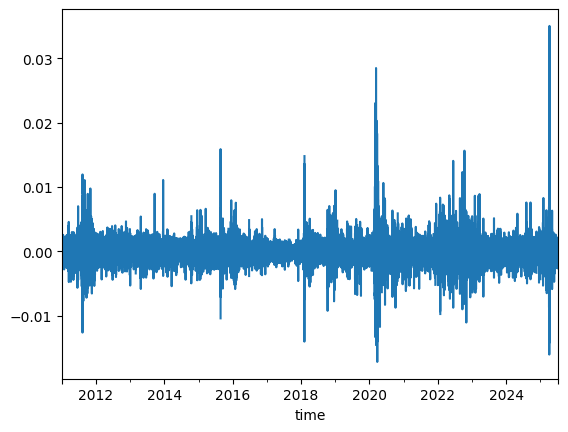

In [5]:
df["ret"] = df["close"].pct_change(fill_method=None)
df["ret"].plot()

## 3. Add time related columns to the dataframe
### 3.1 Add extra columns:
- Add open_time which is the time when market opens for trading
- Add close_time which is the time when market closes for trading
- Add start_time = open_time + 30 mins (30 minutes after market opens)
- Add end_time = close_time - 60 mins (60 minutes before market closes)

In [6]:
df = add_time(df, start_time="+30", end_time="-60")
df

,date,open,high,low,close,volume,ret,open_time,close_time,start_time,end_time
time,,,,,,,,,,,
2011-01-03 14:30:00+00:00,2011-01-03,126.71,126.74,126.66,126.72,2563400.0,NaN,2011-01-03 14:30:00+00:00,2011-01-03 21:00:00+00:00,2011-01-03 15:00:00+00:00,2011-01-03 20:00:00+00:00
2011-01-03 14:35:00+00:00,2011-01-03,126.72,126.81,126.69,126.75,3029500.0,0.000237,2011-01-03 14:30:00+00:00,2011-01-03 21:00:00+00:00,2011-01-03 15:00:00+00:00,2011-01-03 20:00:00+00:00
2011-01-03 14:40:00+00:00,2011-01-03,126.75,126.83,126.72,126.81,2734100.0,0.000473,2011-01-03 14:30:00+00:00,2011-01-03 21:00:00+00:00,2011-01-03 15:00:00+00:00,2011-01-03 20:00:00+00:00
2011-01-03 14:45:00+00:00,2011-01-03,126.81,126.99,126.80,126.95,3299400.0,0.001104,2011-01-03 14:30:00+00:00,2011-01-03 21:00:00+00:00,2011-01-03 15:00:00+00:00,2011-01-03 20:00:00+00:00
2011-01-03 14:50:00+00:00,2011-01-03,126.94,127.10,126.94,127.06,2825100.0,0.000866,2011-01-03 14:30:00+00:00,2011-01-03 21:00:00+00:00,2011-01-03 15:00:00+00:00,2011-01-03 20:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...
2025-07-10 19:40:00+00:00,2025-07-10,626.46,626.54,626.34,626.54,513147.0,0.000112,2025-07-10 13:30:00+00:00,2025-07-10 20:00:00+00:00,2025-07-10 14:00:00+00:00,2025-07-10 19:00:00+00:00
2025-07-10 19:45:00+00:00,2025-07-10,626.54,626.68,626.38,626.38,796113.0,-0.000255,2025-07-10 13:30:00+00:00,2025-07-10 20:00:00+00:00,2025-07-10 14:00:00+00:00,2025-07-10 19:00:00+00:00
2025-07-10 19:50:00+00:00,2025-07-10,626.38,626.39,625.80,625.92,1629609.0,-0.000734,2025-07-10 13:30:00+00:00,2025-07-10 20:00:00+00:00,2025-07-10 14:00:00+00:00,2025-07-10 19:00:00+00:00


### 3.2 Filter the intraday periods (remove opening session and ending session)

In [7]:
df = df[
    (df.index > df["start_time"])
    & (df.index <= df["end_time"])
]

# Run through history and fit extreme value theory to shortlist traded periods

In [8]:
# Init the list to store all traded periods
ALL_TRADES = []

# For loop every day
for i, d in enumerate(df["date"].unique()):
    # Skip checking within the first month due to lack of data for empirical distribution
    if i <= 21:
        prev_d = d
        continue

    # Filter the daily data
    daily_df = df[df["date"]==d]

    # Duplicate data and shift returns series by -1 as we will use future returns for evaluation
    target_ret = daily_df.copy()
    target_ret["ret"] = target_ret["ret"].shift(-1)

    # Locate 4 weeks of returns data up to previous date to form an empirical return distribution
    dist = EmpiricalDistribution(df.loc[(prev_d-timedelta(weeks=4)).strftime("%Y-%m-%d"):prev_d.strftime("%Y-%m-%d"), "ret"])

    # Sampling daily data to every hour data
    for idx, temp_df in daily_df.resample("60min"):
        # Fit the extreme value distribution using empirical distribution with the respective number of trials
        n_trials = np.arange(len(temp_df))+1
        a_n, b_n, expected, cdf_func = fit_evt(dist, n_trials)

        # Shortlist the periods that maximum returns (up to that period) is significantly less than the expected max value
        mask = cdf_func(temp_df["ret"].cummax()) < SIGNIFICANT_LEVEL

        # Filter out too small n_trials
        mask = mask.iloc[MIN_N:]
        mask = mask[mask].index

        # If there is some shortlisted periods, store it to ALL_TRADES list
        if not mask.empty:
            ALL_TRADES.append(target_ret.loc[mask])

    # Assign previous date and move on the the next day
    prev_d = d
    print(d, end="\r")

D:\neveroddoreven\venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


2025-07-10 00:00:00

# Aggregate results and Visualize it

In [9]:
all_trade_df = pd.concat(ALL_TRADES)
all_trade_df

,date,open,high,low,close,volume,ret,open_time,close_time,start_time,end_time
time,,,,,,,,,,,
2011-02-03 18:20:00+00:00,2011-02-03,130.40,130.40,130.30,130.35,832500.0,0.000307,2011-02-03 14:30:00+00:00,2011-02-03 21:00:00+00:00,2011-02-03 15:00:00+00:00,2011-02-03 20:00:00+00:00
2011-02-03 18:25:00+00:00,2011-02-03,130.34,130.41,130.33,130.39,451000.0,0.000153,2011-02-03 14:30:00+00:00,2011-02-03 21:00:00+00:00,2011-02-03 15:00:00+00:00,2011-02-03 20:00:00+00:00
2011-02-03 18:30:00+00:00,2011-02-03,130.39,130.44,130.36,130.41,646400.0,-0.000613,2011-02-03 14:30:00+00:00,2011-02-03 21:00:00+00:00,2011-02-03 15:00:00+00:00,2011-02-03 20:00:00+00:00
2011-02-03 18:35:00+00:00,2011-02-03,130.41,130.41,130.31,130.33,658800.0,0.000307,2011-02-03 14:30:00+00:00,2011-02-03 21:00:00+00:00,2011-02-03 15:00:00+00:00,2011-02-03 20:00:00+00:00
2011-02-03 18:40:00+00:00,2011-02-03,130.33,130.38,130.32,130.37,458600.0,-0.000460,2011-02-03 14:30:00+00:00,2011-02-03 21:00:00+00:00,2011-02-03 15:00:00+00:00,2011-02-03 20:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...
2025-07-10 18:35:00+00:00,2025-07-10,626.63,626.67,626.36,626.44,424165.0,0.000096,2025-07-10 13:30:00+00:00,2025-07-10 20:00:00+00:00,2025-07-10 14:00:00+00:00,2025-07-10 19:00:00+00:00
2025-07-10 18:40:00+00:00,2025-07-10,626.45,626.51,626.33,626.50,386194.0,-0.000335,2025-07-10 13:30:00+00:00,2025-07-10 20:00:00+00:00,2025-07-10 14:00:00+00:00,2025-07-10 19:00:00+00:00
2025-07-10 18:45:00+00:00,2025-07-10,626.50,626.52,626.25,626.29,322829.0,-0.000112,2025-07-10 13:30:00+00:00,2025-07-10 20:00:00+00:00,2025-07-10 14:00:00+00:00,2025-07-10 19:00:00+00:00


In [10]:
shortlisted_returns = all_trade_df["ret"].rename("shortlised")
benchmark_returns = df["ret"].shift(-1).rename("benchmark")  # shift -1 to make it consistent with shortlisted_returns

## Visualize benchmark and result

<Axes: xlabel='time'>

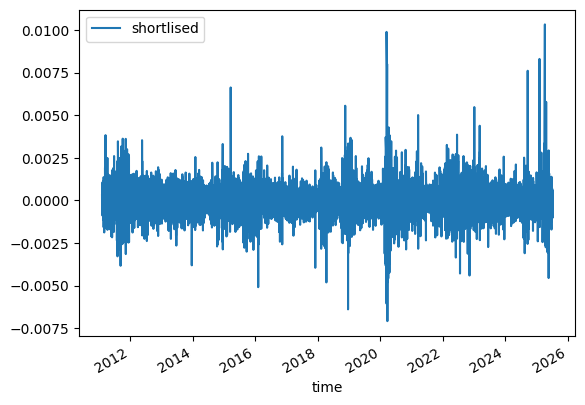

In [11]:
shortlisted_returns.plot(legend=True)

<Axes: xlabel='time'>

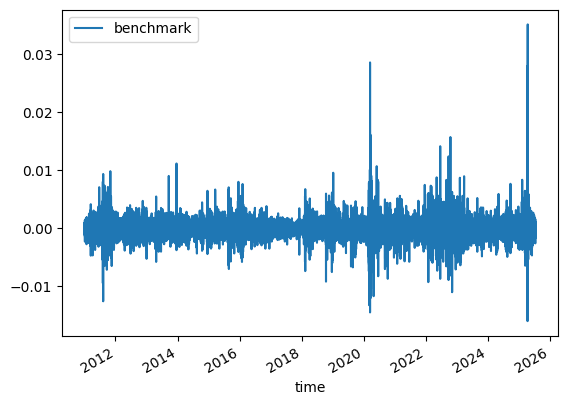

In [12]:
benchmark_returns.plot(legend=True)

<Axes: xlabel='time'>

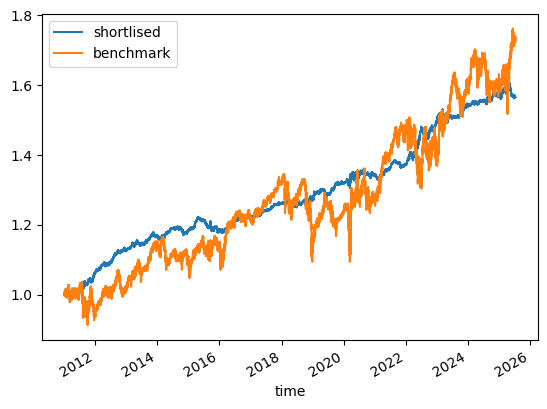

In [13]:
shortlisted_returns.add(1).cumprod().plot(legend=True)
benchmark_returns.add(1).cumprod().plot(legend=True)

&rarr; **Both returns series show uptrend but the shortlisted series has lower volatility and smoother equity curve**

# Hypothesis testing

### Test 1:
Test mean of shortlisted periods is 0 or not:
- Null hypothesis: $\bar{R_t} = 0$
- Alternative hypothesis: $\bar{R_t} > 0$

In [14]:
ttest_1samp(shortlisted_returns, popmean=0, alternative="greater")

TtestResult(statistic=4.4593080724226875, pvalue=4.126340811611443e-06, df=29601)

&rarr; **p value is significantly small which indicates that we can reject null and accept alternative hypothesis**

### Test 2:
Test mean of shortlisted periods is the same as mean of benchmark returns using t-test:
- Null hypothesis: $\bar{R_t} = \bar{B_t}$
- Alternative hypothesis: $\bar{R_t} > \bar{B_t}$

In [15]:
ttest_ind(shortlisted_returns, benchmark_returns, alternative="greater", nan_policy="omit", equal_var=False)

TtestResult(statistic=3.1819567908465936, pvalue=0.000731878034371891, df=48611.23201132423)

&rarr; **p value is significantly small which indicates that we can reject null and accept alternative hypothesis**

# Evaluate Backtest using basic long 1 unit of asset per trade
## 1. Group to daily returns

In [16]:
daily_ret = shortlisted_returns.resample("B").apply(lambda x: x.add(1).prod()-1)

## 2. Evaluate and present metrics

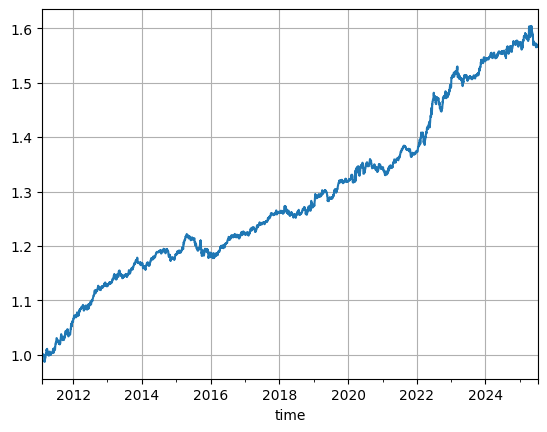

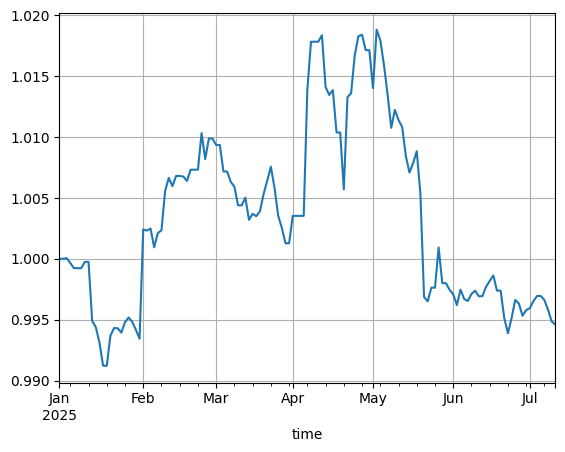

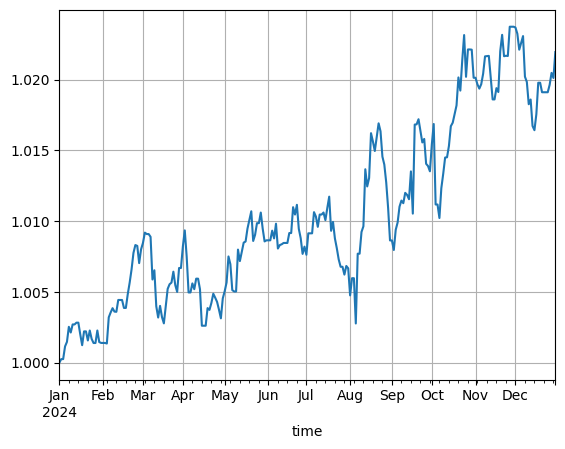

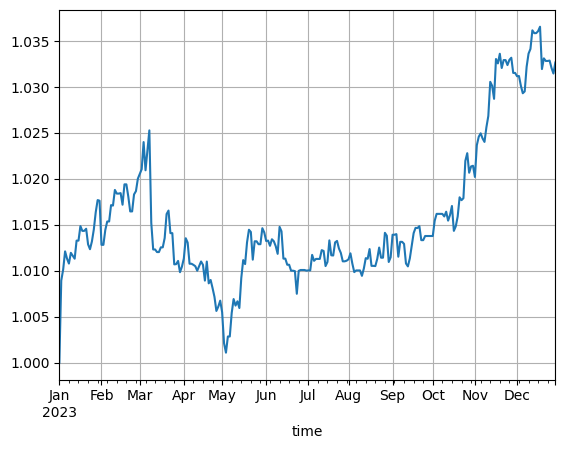

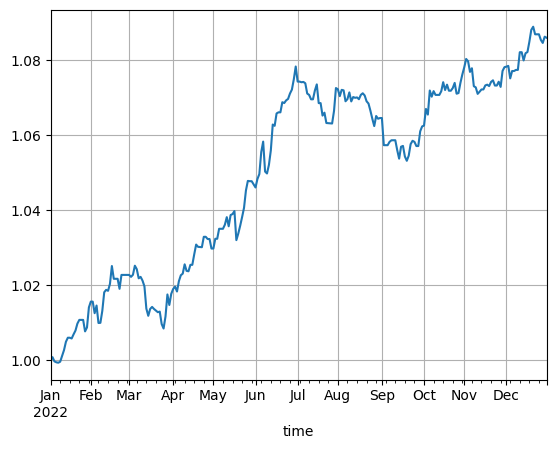

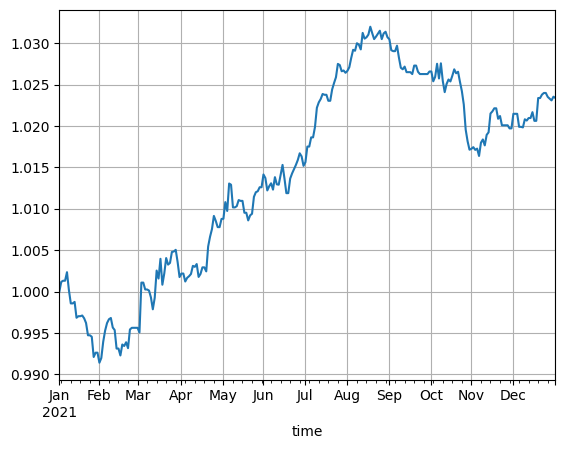

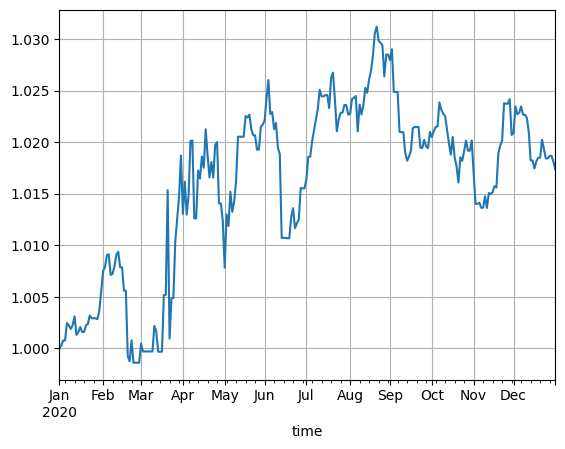

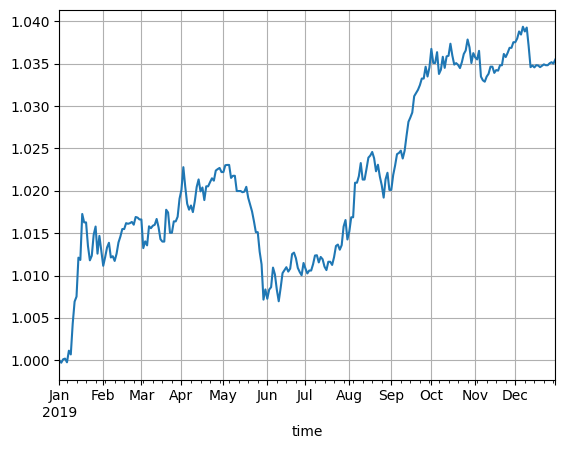

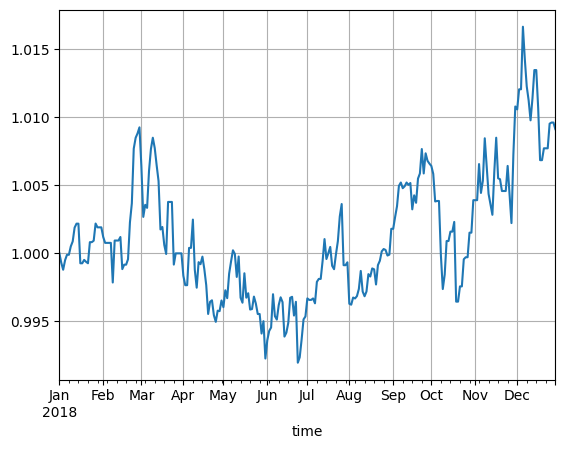

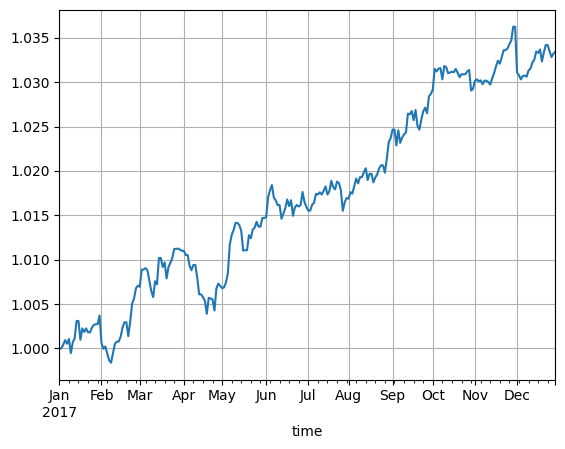

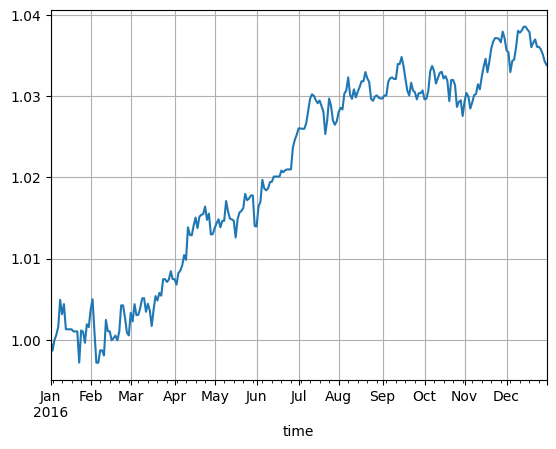

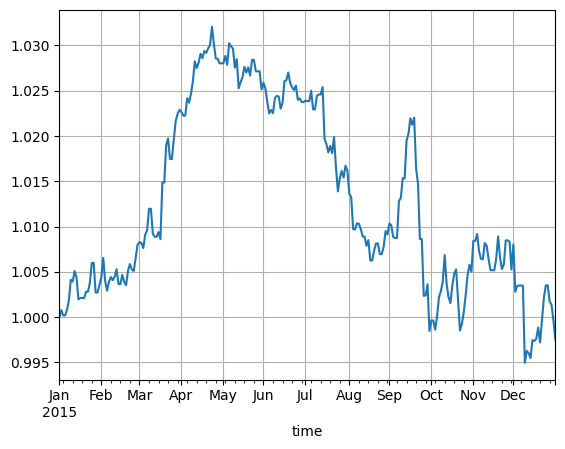

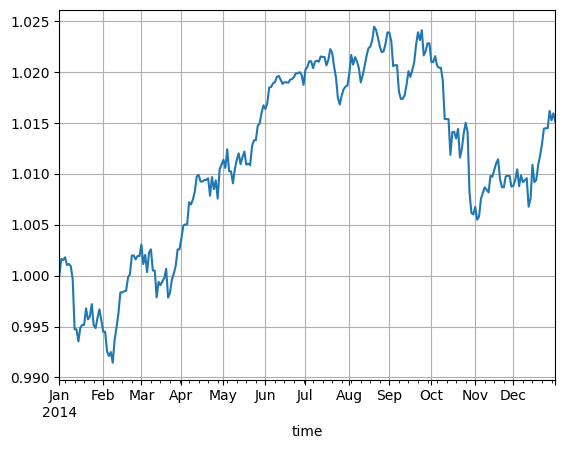

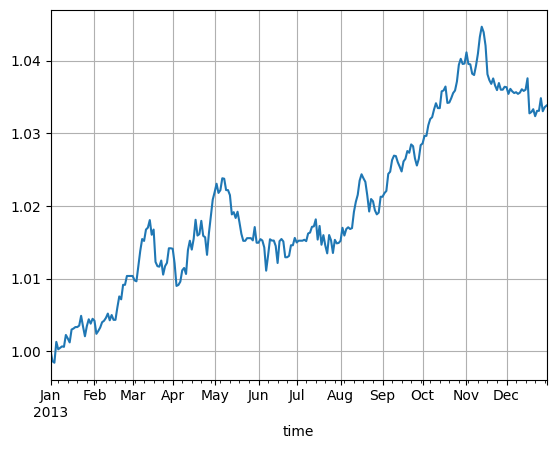

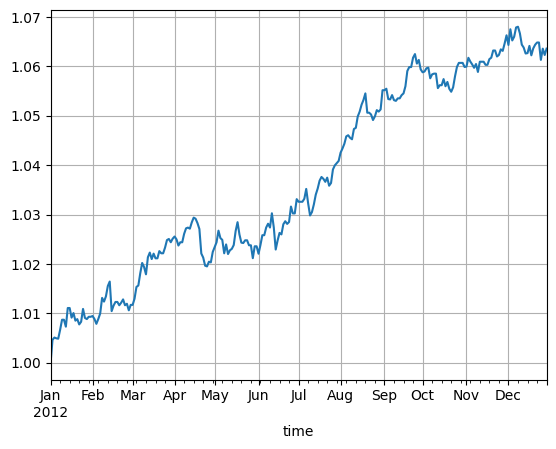

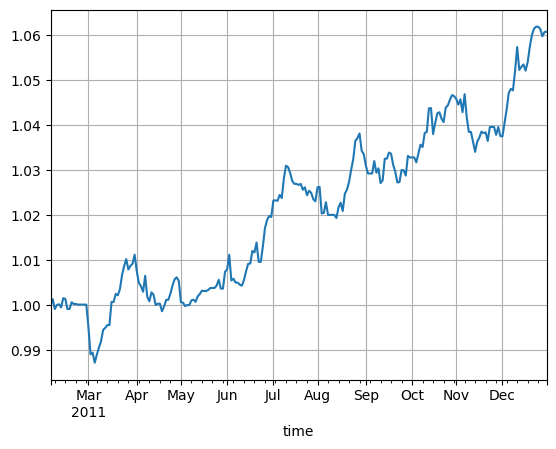

,start_time,end_time,annualized_return,annualized_volatility,sharpe_ratio,sortino_ratio,min_rolling_sharpe,max_drawdown,standardized_max_drawdown,qsharpe_0,qsharpe_0.05,qsharpe_0.1,qsharpe_0.5,qsharpe_1
0,2011-02-03 00:00:00+00:00,2025-07-10 00:00:00+00:00,3.05,2.48,1.23,1.77,-0.85,-3.62,-1.46,-0.85,0.05,0.33,1.34,3.51
0,2025-01-01 00:00:00+00:00,2025-07-10 00:00:00+00:00,-0.99,3.38,-0.29,-0.46,0.21,-2.45,-0.72,0.21,0.25,0.28,0.84,1.44
0,2024-01-01 00:00:00+00:00,2024-12-31 00:00:00+00:00,2.11,1.96,1.07,1.60,0.60,-0.89,-0.45,0.60,0.73,0.82,1.47,2.01
0,2023-01-02 00:00:00+00:00,2023-12-29 00:00:00+00:00,3.16,2.50,1.27,1.84,0.59,-2.36,-0.94,0.59,0.84,0.92,1.45,3.01
0,2022-01-03 00:00:00+00:00,2022-12-30 00:00:00+00:00,8.39,3.34,2.51,3.87,1.48,-2.33,-0.70,1.48,1.64,1.75,2.25,2.85
0,2021-01-01 00:00:00+00:00,2021-12-31 00:00:00+00:00,2.26,1.73,1.31,2.08,-0.08,-2.19,-1.27,-0.08,0.06,0.16,0.81,1.66
0,2020-01-01 00:00:00+00:00,2020-12-31 00:00:00+00:00,1.67,3.40,0.49,0.66,0.39,-1.70,-0.50,0.39,0.46,0.52,1.07,1.64
0,2019-01-01 00:00:00+00:00,2019-12-31 00:00:00+00:00,3.42,1.99,1.72,2.65,0.26,-1.57,-0.79,0.26,0.62,0.75,1.21,2.08
0,2018-01-01 00:00:00+00:00,2018-12-31 00:00:00+00:00,0.88,2.49,0.35,0.48,-0.02,-1.72,-0.69,-0.02,0.16,0.28,0.63,2.49
0,2017-01-02 00:00:00+00:00,2017-12-29 00:00:00+00:00,3.24,1.52,2.13,3.12,1.18,-0.73,-0.48,1.18,1.30,1.38,1.79,2.45


In [17]:
BacktestMetricCalculator(
    daily_ret,
    time_freq="D",
    sub_period=1,
    sharpe_quantiles=[0, 0.05, 0.1, 0.5, 1],
).summarize(True)

&rarr; **The plot shows consistent profit across time**